In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
x = torch.linspace(0,799,800)

In [3]:
y = torch.sin(x*2*3.1416/40)

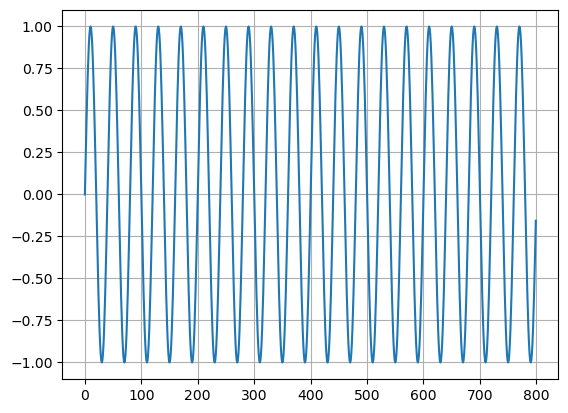

In [4]:
plt.plot(y)
plt.grid(True)

In [5]:
test_size = 40
train_size = len(y)-test_size

In [6]:
train_set = y[:train_size]
test_set = y[train_size:]

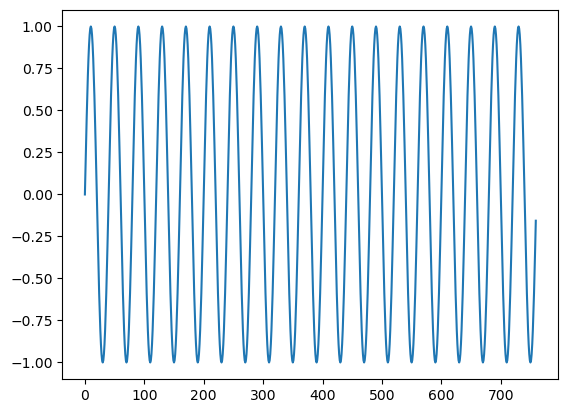

In [7]:
plt.plot(train_set)

In [8]:
def input_data(seq,window_size):
    L = len(seq)
    out = []
    for i in range(L-window_size):
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        out.append((window,label))
    return out

In [9]:
window_size = 40
train_data = input_data(train_set,window_size)

In [10]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [39]:
class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=32,out_size=1,num_layers=2,bidirectional=True):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_dir = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden = (torch.zeros(self.num_layers * self.num_dir,1,hidden_size),
                       torch.zeros(self.num_layers * self.num_dir,1,hidden_size))
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size * self.num_dir, out_size)
    def forward(self,seq):
        lstm_out,self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [40]:
model = LSTM()

In [41]:
model

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, bidirectional=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [42]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
num_epochs = 10
future = 40

epoch : 1 loss : 0.0003616693720687181
loss on test : 0.0032236974220722914


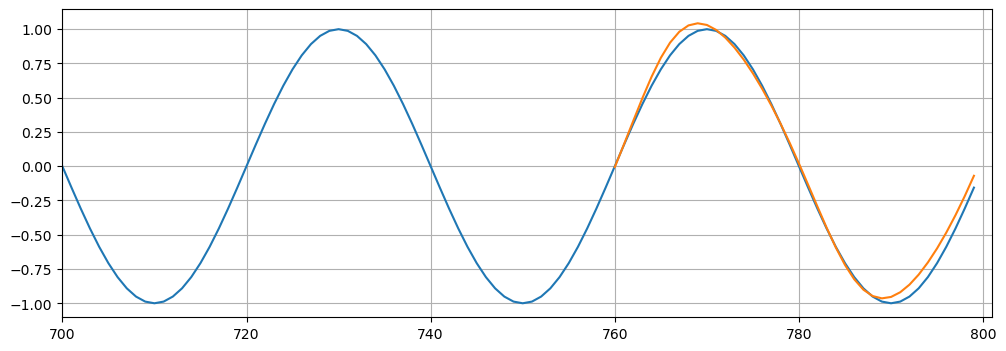

epoch : 2 loss : 0.00034451147075742483
loss on test : 0.0030792378820478916


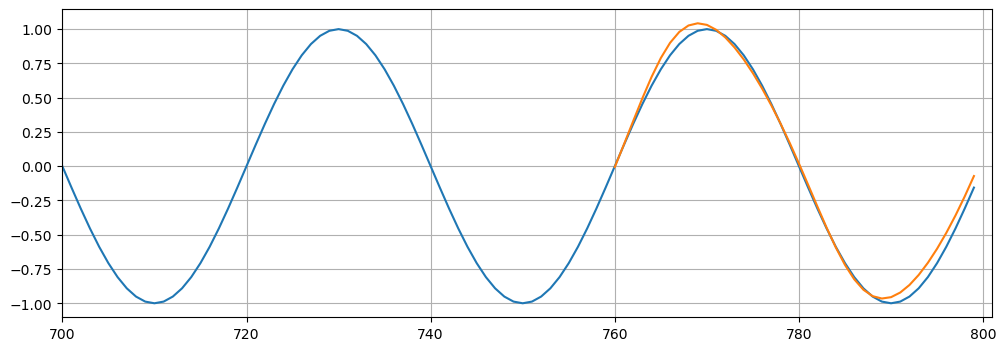

epoch : 3 loss : 0.00032865654793567955
loss on test : 0.0029423474334180355


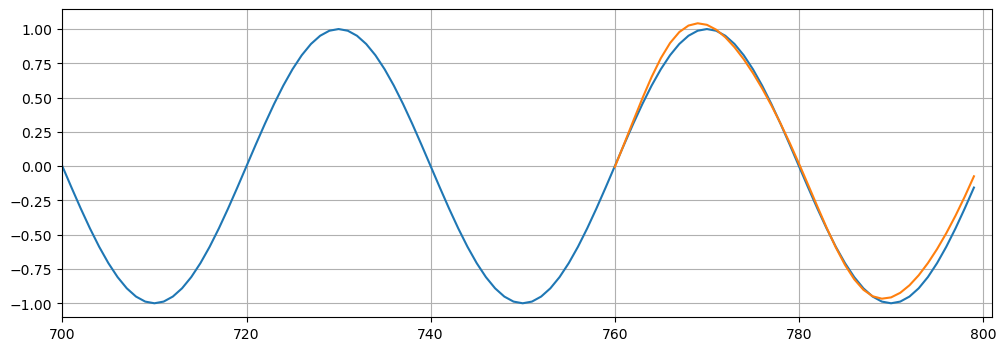

epoch : 4 loss : 0.0003139386826660484
loss on test : 0.002812526887282729


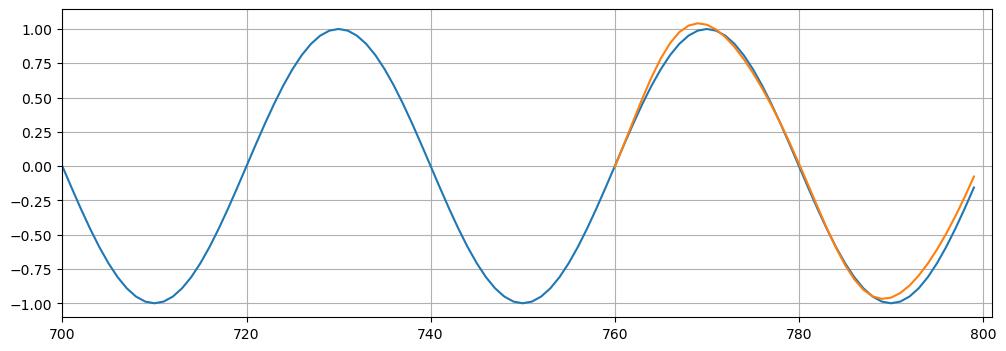

epoch : 5 loss : 0.00030021704151295125
loss on test : 0.0026893930044025183


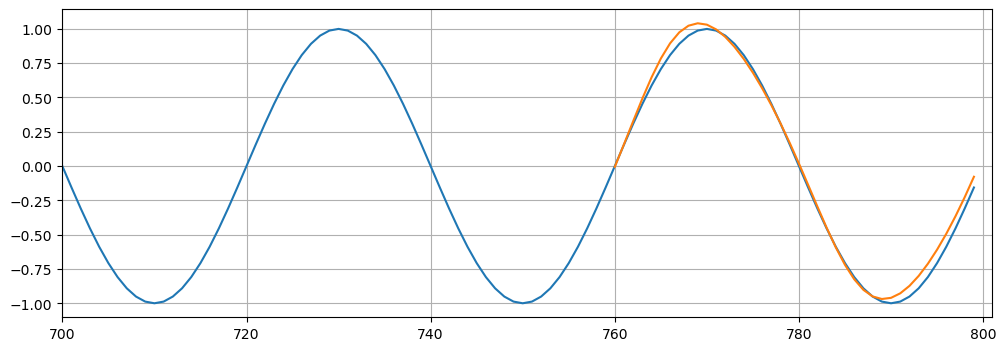

epoch : 6 loss : 0.0002873907797038555
loss on test : 0.0025723506696522236


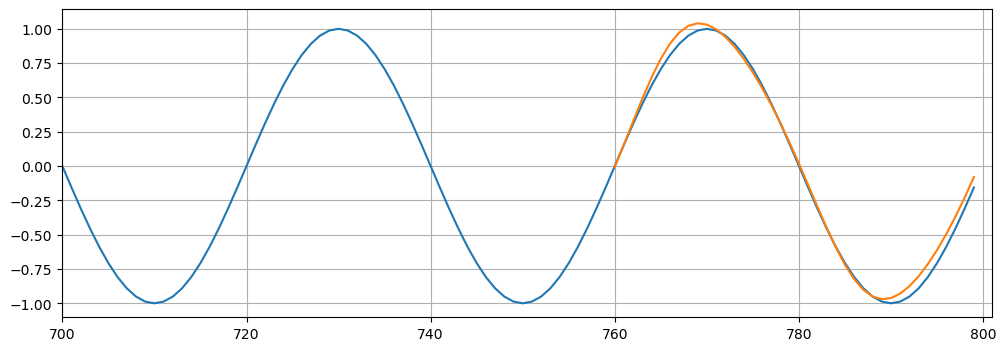

epoch : 7 loss : 0.000275366532150656
loss on test : 0.0024611209519207478


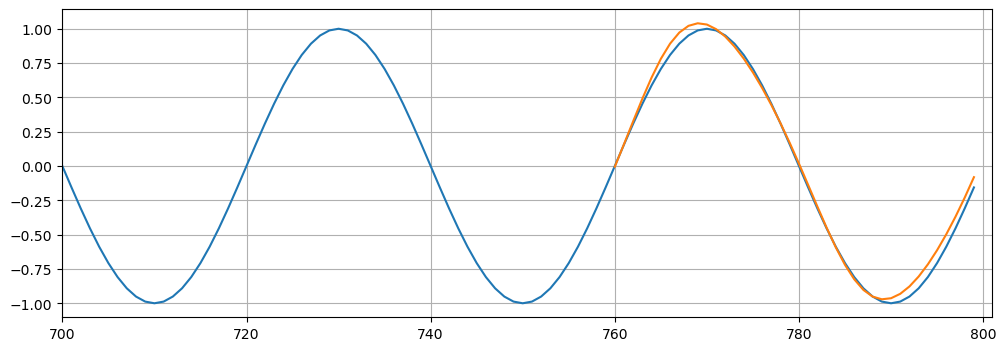

epoch : 8 loss : 0.000264061993220821
loss on test : 0.00235524820163846


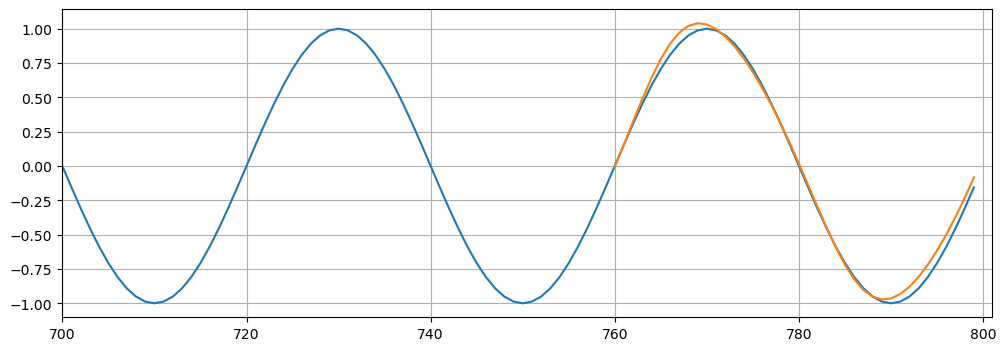

epoch : 9 loss : 0.00025342736626043916
loss on test : 0.0022543934173882008


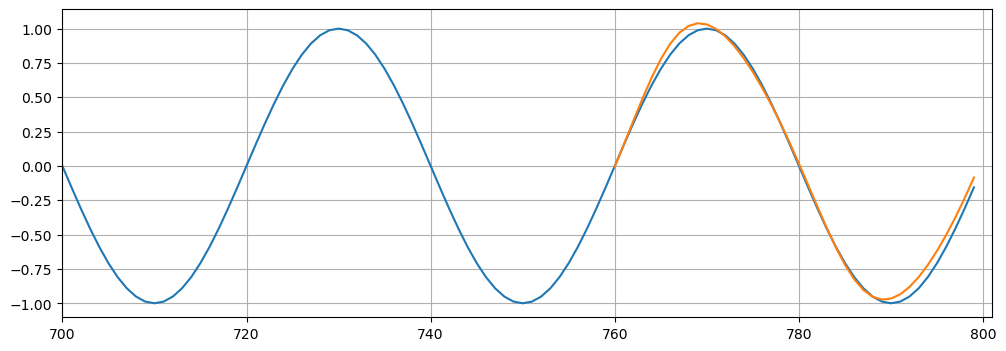

epoch : 10 loss : 0.00024339660012628883
loss on test : 0.0021583468187600374


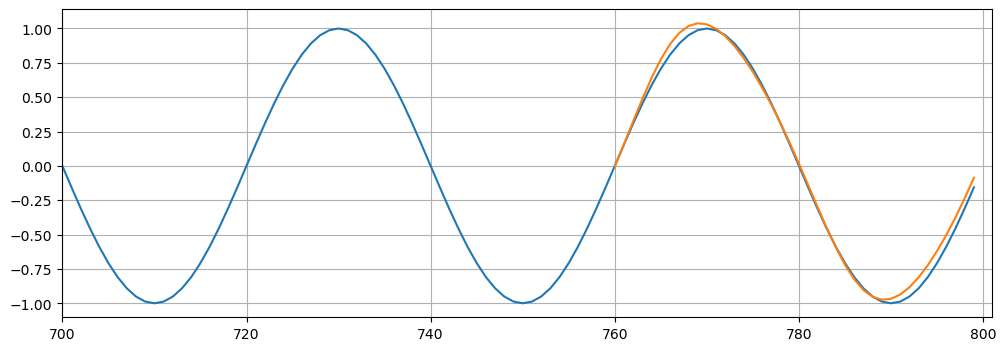

In [47]:
#for every epoch
for epoch in range(num_epochs):
    #for every sequence and its label
    for seq,label in train_data:
        #clean state
        optimizer.zero_grad()
        model.hidden = (torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size),
                       torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size)) 
        y_pred = model.forward(seq)
        loss = criterion(y_pred,label)
        loss.backward()
        optimizer.step()
    print(f"epoch : {epoch+1} loss : {loss.item()}")
    
    #end of training, now test function
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = torch.Tensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size),
                           torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size)) 
            preds.append(model.forward(seq).item())
    loss = criterion(torch.Tensor(preds[-window_size:]),test_set)
    print(f"loss on test : {loss.item()}")
        # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()
              
        